# Classification and Clustering

In [2]:
# ! pip install pyamg #pyamg for efficient solving for spectral clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import collections, re, string, glob, collections, pickle, os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cluster import SpectralClustering
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn import metrics
from scipy.sparse import hstack
from imblearn import over_sampling

import utils_vectoriser

In [ ]:
## TO DO:
# 1. pipeline the feature set generation process - separate .py 

# 2. pipeline the model training and eval process  - separate .py 

# 3. tune clustering first so that we get meaningful cluster results on the test set. Use cluster able to augment 
# training of classifier. Meaningful evaluation of clusters include author's literary movements, but this is multilabel 
# for each author, need to understand how to meaningful compare that with cluster labels. Current idea: vectorise the 
# literary movements labels - which will give some similiarity matrix across all authors, based on their membership 
# in the literary movement tag. Use this to to evaluate cluster labels. Will need to figure out logic of doing so, 
# possibility and mechanics of this 

### Initial results

##### Clustering
|Run   	|Classifier   	|Featureset   	|train acc   	|test acc   	|alpha/C   	|
|---	|---	|---	|---	|---	|---	|
|1   	|LogReg - baseline   	|1sent: lemmas,    	|0.78   	|0.35   	|1   	|
|1a   	|M_NB   	|1sent: lemmas,    	|0.93   	|0.27   	|0.1   	|
|1b   	|LogReg, OVR, L2   	|1sent: lemmas   	|not converging   	|-   	|-   	|
|2  	|LogReg - baseline   	|1sent: lemmas, parse_VP, subjectivity    	|0.83   	|0.35   	|1   	|
|2b   	|M_NB   	|1sent: lemmas, parse_VP, subjectivity    	|99.43.893   	|27.52   	|0.0   	|
|2a   	|LogReg, OVR, L2   	|1sent: lemmas, parse_VP, subjectivity   	|not converging   	|-   	|-   	|
|3   	|LogReg, OVR, L1, with MaxAbsScaler   	|1sent: lemmas   	|0.99  	|0.39   	|1   	|
|4   	|LogRegCV, OVR, L2 no MaxAbsScaler   	|5sent: subj, filteredtokens, parse_VP, no TSVD   	|0.97   	|0.12   	|1   	|
|5   	|LogRegCV, OVR, L2 no MaxAbsScaler   	|5sent: subj, filteredtokens, parse_VP, book_ners, no TSVD   	|0.97   	|0.19   	|1   	|
|6   	|LogRegCV, OVR, L2 with MaxAbsScaler   	|5sent: subj, filteredtokens, parse_VP, book_ners, no TSVD   	|0.97   	|0.047   	|1   	|
|7   	|LogRegCV, OVR, L2 no MaxAbsScaler   	|5sent: subj, filteredtokens, parse_VP, book_ners, TSVD1000   	|0.97   	|0.16   	|1   	|

It appears our dataset is not structured in a manner that allows us to predict author identities with high accuracy on the test set. We began with 1 sentence per author as an instance and the result (accurary of under 0.4, or worse than chance) and was not promising. We tried generating instances of larger sizes (3 and 5 sentences) within the constraints of the corpus, but the accuracy on test data worsened. 

We think some factors include: 
1. initially, our instances (due to initial collection architecture decisions) in the corpus relates to 1 sentence from an author's book. our randomised approach in selection of the sentences in part 1 and 2 means we cannot find sequential sentences to concat - this will be the most sound. (our subsequent experiments - runs 4 onwards - with concatenated sentences supports the initial hypothesis that randomly joining sentences would introduce noise to the data)
2. limitation to Naive Bayes and Logistic Regression classifiers; other ensemble methods (RandomForest and Decision Trees), as well as non-linear vector models (SVM) may perform (slightly?) better. 
3. small to medium-sized datasets with sparse structures for large to very large multi-class prediction problems is a bad combination. it twins an increase in the complexity of the learning task with limited learning examples. 


__Exploration stuff__
Since our tests so far have poor accuracy results. We will require a fundamental review of the data collection structure (number of sentences, how books and sentences were selected). 
1. regenerate dataset to group larger n sentences from an author's book, in order to make every instance larger
2. ngrams - especially with instances with larger n x sentences - better capture contextual information 
3. imbalearn upsampling - probably less useful since the bulk of our train set is balanced across classes.
4. tuning TFIDF levels - setting different norms (probably less useful)

__Bells and whistles__
1. pipeline to save models, capture featuresets used and results 

##### Clustering
We thought to implement spectral clustering as a baseline since it [appears](https://scikit-learn.org/stable/modules/clustering.html#) to generalise well over different data distributions. We started with 10 authors with 19 distinct literary movements, but the clustering was not meaningful. When reduced to 3 principal compnents with Truncated SVD for visualisation, we observe two broad clusters that come together for an hourglass-ish form. One of the main clusters is significantly dense, which potentially involve sub-clusters embedded within it. We will need to study and explore other clustering algorithms that would better handle this distribution. Finally, we also face a problem with cluster evaluation since the labels we expect to measure them by are multilabels.  

##### Salient points: 
1. making sure smooth_idf=True (default value) in TfidfTransformer, so that we don't end up with probabilities of 0
2. only generalised linear models (i.e. logreg and SVM linear) take negative values. consider this in featureset selection architecture when creating pipeline. negative values not possible for naive bayes (since negative priors impossible)
- to use our concreteness score in naive bayes which is based on a 0-centred scale, we will probably need to countvectorise (for each of the instance in the corpus, with the words in the concreteness dataset as the vocab). - this is probably a bad idea for this task - it will be adding another very sparse matrix to the featureset. 
- scaling sparse data with MaxAbsScaler
- TruncatedSVD instead of PCA for sparse matrices

### 1. Create training and evaluation sets

#### 1a. Corollary: Computing a subjectivity score

We have access to a set of [subjectivity classification for about 8,200 English words](https://gitlab.inria.fr/mastertal/UE803/blob/master/data/l10_data/subjectivity_clues_hltemnlp05/subjclueslen1-HLTEMNLP05.README). We hypothesize that an average subjectivity score can help to further distinguish between authors. 
Our datapoints are however single sentences from at least 3 books of an author, and it is not sensible to compute the score for every sentence as there can be significant variability for such a score between an author's ouevre. Instead we compute the score based on the entire set of the author's sentences admitted into our corpus. 

We hypothesize that ideally, it will be better to compute the score based on each set of sentences from a single book of one author. This could provide a better predictor of an author's identity, by capturing a certain understanding about the subjectivity, and variability of the subjectivity, of his/her body of work. 

In [3]:
with open("../2_Preprocessing/supportdata/SubjectivityClues/data_l10_data_subjectivity_clues_hltemnlp05_subjclueslen1-HLTEMNLP05.tff", 
          "r") as file:
    subjectivityclues_all = file.read()
    
subj_scores = [1 if i == "type=weaksubj" else 2 for i in re.findall(r"type=[a-z]+", subjectivityclues_all)]
# encoding 1 and 2, since the classes are ordinal - "weaksubj" and "strongsubj"
subj_words = [i.lstrip("word1=") for i in re.findall(r"word1=[a-z]+", subjectivityclues_all)]
subj_pos = [i.lstrip("pos1=") for i in re.findall(r"pos1=[a-z]+", subjectivityclues_all)]
# side note on pos and stemming: the dataset does not use the UD POS tags, so we cannot map the tokens more precisely
# based on the POS tag we have for the corpus tokens. also, the Wilson et al 2005 data include whether the words were 
# stemmed (i.e. usable on our lemmas sets), but it numbers only 1620, out of 8222 words, or less than 20%. so we 
# should compute our subjectivity score using our tokens set instead of lemmas

subj_trip_info = [i for i in zip(subj_scores, subj_pos)]
__dictcombined = {subj_words[index]: subj_trip_info[index] for index in range(len(subj_words))}
# there are 5 words that have zero length and it is throwing an error in the filtering.
# also pointless to have a score for an empty string in the computation of the subjectivity score. 
# it might have come about at the re.findall level, but the empty word issue still persists
# after adding A-Z and 1-9 to the search pattern. 
__dictcombined_filter = {i: __dictcombined[i] for i in __dictcombined if len(i) > 0}

# sort into a dictionary to speed search time 
subj_dict = {}
for letter in string.ascii_lowercase: 
    subj_dict[letter] = {key:__dictcombined_filter[key] for key in __dictcombined_filter if key[0] == letter}
    

In [4]:
def get_subjectivity(spacysentdoc, subj_dict):
    '''given a spacysentdoc, or a np array of strings (tokens of a sentence), returns the subjectivity
    score for the sentence. The score is the sum of the score for tokens that can be 
    found in the http://crr.ugent.be/archives/1330 dataset. 
    Inputs: spacysentdoc
    Outputs: a tuple containing the function name and the result. result is an integer rounded to 3 dp 
    and converted to a string
    ''' 
    if type(spacysentdoc) == np.ndarray: 
        s_score = 0
        for sentence in spacysentdoc: 
            for token in sentence:
                try:
                    # using first letter of token, go to sub-dict of subj_dict
                    # if the token is one of the values of the sub-dict
                    # retrive the subjectivity score
                    if token in subj_dict[token[0]].keys():
                        s_score += int(subj_dict[token[0]][token][0])
                except: 
                    pass
        # the score is averaged across the number of tokens across the entire corpus/doc
        # it gives an indication of the usage of subjectivity words in writing style
        return "subjectivity", round(s_score/len(spacysentdoc), 3)
    else: 
        # condition for code extension to cover spacysentdoc (for alignment to insert into utils_tokeniser.py)
        pass
    

#### 1b. Importing pickled DFs, train-test split

__General approach__

1. iteratively load author pickled dfs, filter out sentences that are less than 10 tokens long (between the 25th and 50th percentile for sentence length across the entire corpus of all authors)
    - (since our dataset is built on one sentence per author, we drop sentences to avoid the possibility of an extremely sparse matrix. the short sentences would provide limited linguistics indicators (expressed through word freqency counts, ) to distinguish between authors. 
    - plus we already have sent_length and a high-level overview of a sentence's constituency structure as features
    - add author wiki abstract NERs
2. cut into train test split on each load (to ensure each author is evenly represented in the train and test sets)
3. concat train at end, concat test at end
4. fit tfidf on train (so as not to leak test data into train), transform on train and test
5. cut into sets of features
6. export to svm light 

__Data integrity checkpoint__

We could not complete preprocessing for 3 authors admitted into the corpus by Phase 1. An issue with the contents of their sentences is causing the constituency parser to break. 

In [5]:
# set global variables
FEATURESET_CLASS = "1_sent"

##### Preliminaries #####
# 0. grab all the pickled df files
df_filenames = glob.glob("../2_Preprocessing/processeddata/df_pickles/{}/*.pickle".format(FEATURESET_CLASS))

# 1a. lists for collecting all the df objects to be generated for pd.concat - speediest approach 
# https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/24913075#24913075
dfs_list_train = [] 
dfs_list_test = []


# 1b. store author-label mapping
label2auth_map = {}
auth2label_map = {}


##### Processing #####
# 2. generate the master DF
label_counter = 1
for filename in df_filenames: 
    __ = pd.read_pickle(filename)
     
    authornum = __["authornum"][0]                             # get the authornum for this df   
                                
    label2auth_map[label_counter] = authornum                  # switch the authornum to int, store the mapping
    auth2label_map[authornum] = label_counter
    __["authornum"] = label_counter
    
    __ = __[__["sent_length"]>10]                               # - filter out short sentences
    __["concreteness"] = __["concreteness"].astype(float)       # - we set the concreteness score as a string in order
                                                                # to run the process_one_author functions easily
                                                                # switching back to int here
    # get the subjectivity score for the author. 
    s_score = get_subjectivity(__["tokens"].values,subj_dict)[1]
    # add as a new column to this df
    __["subjectivity"]=s_score
    

    # train test split 
    __train, __test = train_test_split(__, test_size=0.20)
    dfs_list_train.append(__train)
    dfs_list_test.append(__test)
    
    label_counter += 1
    
allauthor_df_train = pd.concat(dfs_list_train, axis=0)
allauthor_df_test = pd.concat(dfs_list_test, axis=0)
allauthor_df_train.reset_index(drop= True, inplace=True)
allauthor_df_test.reset_index(drop= True, inplace=True)

print("train size: {}, test size: {}".format(allauthor_df_train.shape, allauthor_df_test.shape))

train size: (13837, 33), test size: (3518, 33)


In [6]:
# overview stats
allauthor_df_test.describe()

,authornum,concreteness,parse_NP,parse_S,parse_VP,pos_ADJ,pos_ADP,pos_ADV,pos_AUX,pos_CCONJ,...,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_SYM,pos_VERB,pos_X,sent_length,subjectivity
count,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.0,3518.000000,...,3518.000000,3518.000000,3518.000000,3518.0,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000
mean,57.490335,-0.169150,9.507106,3.596077,5.405344,2.986356,3.713189,1.852473,0.0,1.196987,...,1.864696,1.144116,4.023309,0.0,0.360432,0.004548,4.998294,0.010802,27.053439,5.833819
std,33.208405,6.555305,6.959923,2.517554,3.897171,2.970586,3.391756,1.893259,0.0,1.383160,...,1.781942,2.837156,3.561159,0.0,1.299698,0.106549,3.438480,0.161375,19.705768,1.710686
min,1.000000,-92.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,11.000000,2.491000
25%,28.000000,-3.460000,5.000000,2.000000,3.000000,1.000000,2.000000,1.000000,0.0,0.000000,...,1.000000,0.000000,2.000000,0.0,0.000000,0.000000,3.000000,0.000000,16.000000,4.379000
50%,58.000000,0.030000,8.000000,3.000000,5.000000,2.000000,3.000000,1.000000,0.0,1.000000,...,1.000000,0.000000,3.000000,0.0,0.000000,0.000000,4.000000,0.000000,22.000000,5.764000
75%,86.000000,3.360000,12.000000,5.000000,7.000000,4.000000,5.000000,3.000000,0.0,2.000000,...,3.000000,2.000000,5.000000,0.0,0.000000,0.000000,6.000000,0.000000,32.000000,6.790000
max,115.000000,61.820000,92.000000,27.000000,41.000000,45.000000,66.000000,19.000000,0.0,12.000000,...,17.000000,128.000000,107.000000,0.0,26.000000,5.000000,40.000000,6.000000,443.000000,11.402000


In [7]:
# generate a new column with each row containing only tokens that have POS of NOUN, VERB, ADJ or ADV
pos_to_keep = ["NOUN", "VERB", "ADJ" or "ADV"]
allauthor_df_train["filteredtokens"] = allauthor_df_train["poswordpairs"].apply(lambda x: [i[1] for i in x if i[0] in pos_to_keep])
allauthor_df_test["filteredtokens"] = allauthor_df_test["poswordpairs"].apply(lambda x: [i[1] for i in x if i[0] in pos_to_keep])


In [8]:
# check object types - ints/floats, categoricals etc
allauthor_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 34 columns):
authornum         3518 non-null int64
concreteness      3518 non-null float64
lemmas            3518 non-null object
ne_dates          3518 non-null object
ne_persons        3518 non-null object
ne_places         3518 non-null object
parse_NP          3518 non-null int64
parse_S           3518 non-null int64
parse_VP          3518 non-null int64
pos_ADJ           3518 non-null int64
pos_ADP           3518 non-null int64
pos_ADV           3518 non-null int64
pos_AUX           3518 non-null int64
pos_CCONJ         3518 non-null int64
pos_CONJ          3518 non-null int64
pos_DET           3518 non-null int64
pos_INTJ          3518 non-null int64
pos_NOUN          3518 non-null int64
pos_NUM           3518 non-null int64
pos_PART          3518 non-null int64
pos_PRON          3518 non-null int64
pos_PROPN         3518 non-null int64
pos_PUNCT         3518 non-null int64
pos_SCONJ    

#### 1c. Exploring the dataset

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


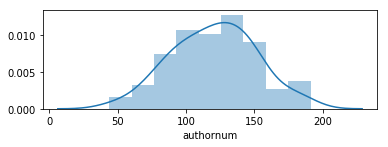

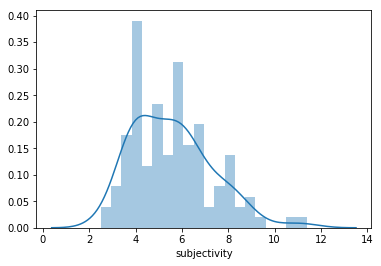

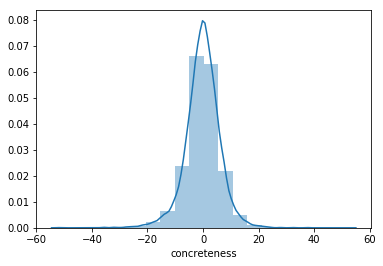

In [9]:
plt.subplot(2, 1, 2)
# let's take a look at the population distribution, to see if we need to finetune the corpus or augment datapoints
sns.distplot(allauthor_df_train.groupby("authornum")["authornum"].count())
plt.show()
# distribution of mean subjectivity score for each author's sentences  
sns.distplot(allauthor_df_train.groupby(["authornum","subjectivity"])["subjectivity"].mean(), bins=20)
plt.show()
# distribution of mean concreteness score for each author's sentences  
sns.distplot(allauthor_df_train.groupby(["authornum","concreteness"])["concreteness"].mean(), bins=20)
plt.show()

#### 1d. Vectorising lemmas and NERs

Our custom vectoriser in utils_vectoriser.py is not appropriate for this task. It implements [tf-max]( https://nlp.stanford.edu/IR-book/html/htmledition/maximum-tf-normalization-1.html) which is useful when working with a set that has document level data. Our current tf-max code set-up is not useful for our featureset structure here (we have no way to normalise over the docset (a book of an author's)). Instead, we use sklearn's TfidTransformer with DictVectoriser, since we already have a set of tokens and lemmas from our earlier custom preprocessing. 

In [10]:
def make_featuresets(needvect_features, alreadyvect_features, task=""):  
    if not os.path.exists("data/{}/{}/".format(FEATURESET_CLASS, task)):
        os.makedirs("data/{}/{}/".format(FEATURESET_CLASS, task))
    for feat in needvect_features:

        # train data - generate DictCounts
        token_Counters_train = []
        for row in needvect_features[feat]["train"].index:
            token_Counters_train.append(collections.Counter(needvect_features[feat]["train"][row]))

        # test data - generate DictCounts
        token_Counters_test = []
        for row in needvect_features[feat]["test"].index:
            token_Counters_test.append(collections.Counter(needvect_features[feat]["test"][row]))

        # transforming test set based on the train set fit 
        # pass the DictCounts into DictVectorizer() 

        Dvectoriser = DictVectorizer()
        Dvect_result_train = Dvectoriser.fit_transform(token_Counters_train)
        Dvect_result_test = Dvectoriser.transform(token_Counters_test)

        Ttransformer = TfidfTransformer(smooth_idf=True) #
        Ttrans_results_train = Ttransformer.fit_transform(Dvect_result_train)
        Ttrans_results_test = Ttransformer.transform(Dvect_result_test)

        # write to SVM
        dump_svmlight_file(Ttrans_results_train, allauthor_df_train["authornum"], 
                           "data/{}/{}/train_{}".format(FEATURESET_CLASS, task, feat)+".svmlight")
        dump_svmlight_file(Ttrans_results_test, allauthor_df_test["authornum"], 
                           "data/{}/{}/test_{}".format(FEATURESET_CLASS, task, feat)+".svmlight")
    for feat in alreadyvect_features:
        # .reshapes since we are working with single feature sets each time 
        dump_svmlight_file(allauthor_df_train[feat].values.reshape(-1,1),
                           allauthor_df_train["authornum"], 
                           "data/{}/{}/train_{}".format(FEATURESET_CLASS, task, feat)+".svmlight")
        dump_svmlight_file(allauthor_df_test[feat].values.reshape(-1,1), 
                           allauthor_df_test["authornum"], 
                           "data/{}/{}/test_{}".format(FEATURESET_CLASS, task, feat)+".svmlight")     

In [12]:
# defining features and running make_featuresets
needvect_features = {"lemmas": 
                  {"train": allauthor_df_train["tokens"],
                    "test": allauthor_df_test["tokens"],},
                "namedentities": 
                  {"train": allauthor_df_train['ne_dates']+allauthor_df_train['ne_places'],
                   "test": allauthor_df_test['ne_dates']+allauthor_df_test['ne_places'],}, 
                "filteredtokens": 
                    {"train": allauthor_df_train['filteredtokens']+allauthor_df_train['filteredtokens'],
                   "test": allauthor_df_test['filteredtokens']+allauthor_df_test['filteredtokens'],}}
                # add the ne_dates and ne_places columns for the vectoriser to manage sparsity. leave out 
                # persons for now, it is possible person names can significantly identify authors (except 
                # perhaps authors) 
            
alreadyvect_features=['concreteness', 'subjectivity', "parse_VP"]

make_featuresets(needvect_features, alreadyvect_features, task="classification")

In [13]:
allauthor_df_train.columns

Index(['authornum', 'concreteness', 'lemmas', 'ne_dates', 'ne_persons',
       'ne_places', 'parse_NP', 'parse_S', 'parse_VP', 'pos_ADJ', 'pos_ADP',
       'pos_ADV', 'pos_AUX', 'pos_CCONJ', 'pos_CONJ', 'pos_DET', 'pos_INTJ',
       'pos_NOUN', 'pos_NUM', 'pos_PART', 'pos_PRON', 'pos_PROPN', 'pos_PUNCT',
       'pos_SCONJ', 'pos_SPACE', 'pos_SYM', 'pos_VERB', 'pos_X',
       'poswordpairs', 'sentences', 'tokens', 'sent_length', 'subjectivity',
       'filteredtokens'],
      dtype='object')

### 2. Large multiclass classification 

#### 2a. Loading the featuresets and stacking them

In [14]:
def load_data(FEATURESET_CLASS, data_path = "./data/{}/{}/", features='lemmas', task=""):
    '''
    '''
    X_train, y_train = load_svmlight_file( data_path.format(FEATURESET_CLASS, task)+'train_'+features+".svmlight" ) 
    X_test, y_test = load_svmlight_file( data_path.format(FEATURESET_CLASS, task)+'test_'+features+".svmlight", 
                                        n_features=X_train.shape[1] ) 
    # shape of test shouldn't matter here since we enforced it at the vectorising step above (otherwise feature 
    # and vocab won't match between train and test sets )
    
    return X_train, y_train, X_test, y_test

In [49]:
def stack( A, B ):
    return hstack( [A,B] )

X_tr_lemmas, y_train, X_te_lemmas, y_test = load_data( FEATURESET_CLASS, 
                                                    features='lemmas', task="classification")
X_tr_concreteness, y_train, X_te_concreteness, y_test = load_data( FEATURESET_CLASS, 
                                                    features='concreteness', task="classification")
X_tr_namedentities, y_train, X_te_namedentities, y_test = load_data( FEATURESET_CLASS, 
                                                    features='namedentities', task="classification")
X_tr_parse_VP, y_train, X_te_parse_VP, y_test = load_data( FEATURESET_CLASS, 
                                                    features='parse_VP', task="classification")
X_tr_subjectivity, y_train, X_te_subjectivity, y_test = load_data( FEATURESET_CLASS, 
                                                    features='subjectivity', task="classification")
X_tr_filteredtokens, y_train, X_te_filteredtokens, y_test = load_data( FEATURESET_CLASS, 
                                                    features='filteredtokens', task="classification")


X_train = hstack( [ X_tr_lemmas, X_tr_parse_VP, X_tr_subjectivity] )
X_test = hstack( [ X_te_lemmas, X_te_parse_VP, X_te_subjectivity] )

#### 2b. Checking the features size and label distribution

In [50]:
X_train.shape

(13837, 30307)

In [51]:
X_test.shape

(3518, 30307)

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


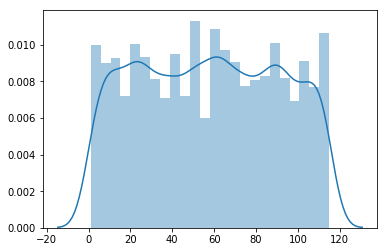

In [44]:
# The distribution of lables in the train set is a little uneven - we could try SMOTE upsampling (since we don't have 
# a very large dataset, so downsampling could worsen the learning)
sns.distplot(y_train)

__A. Dimensionality reduction to explore the characteristics of the data.__

We have a very sparse matrix of about 25,000 features. This is confusing the learning for the classifier, let's reduce dimensions to 5000, instead of 25,000, to see it's impact.  

In [ ]:
# scale with MaxAbsScaler, to retain sparsity structure. Hopefully it will speed up computation for dim reduction. 
# Would allow us to include concreteness score (which has negative values) in the featureset, but need to investigate 
# (i) sensibility of our earlier centering of the concreteness score about -2.5 and 2.5. 
# And if so, does MaxAbsScale entirely negate that? If so, better to leave out concreteness score as a feature

mas = MaxAbsScaler()
mas.fit(X_train)
X_train_mas = mas.transform(X_train)
X_test_mas = mas.transform(X_test)

In [ ]:
for n_components in [5,2500, 10000]:
    TSVD_model = TruncatedSVD(n_components=n_components, random_state=1,)
    X_train_TSVD_model = TSVD_model.fit(X_train)
    print("The explained variance for TruncatedSVD with {} is {}".format(n_components, sum(TSVD_model.explained_variance_ratio_)))

In [ ]:
X_train_TSVD=X_train_TSVD_model.transform(X_train)
X_test_TSVD=X_train_TSVD_model.transform(X_test)

__B. Attempt at NMF to ensure non-negative values (which PCA allows)__

Post-PCA, our train set contains negative values and MultinomialNB does not accept that (although, fine for LogReg since it's a linear model). 

In [ ]:
n_components = 5000
nmf_model = NMF(n_components=n_components, init="nndsvdar", random_state=1, beta_loss="frobenius",
          alpha=.5, l1_ratio=.5, ) 
# We hypothesise that there are a lot of unnnecessary features, so we start by setting 
# a higher alpha for stronger regularisation (drive the weight of the unnecessary features to zero).
# We experiment with a 0.5 L1-L2 regularisation ratio. 
# nndsvdar for faster computation: too little RAM on our PCs :(

X_train_NMF = nmf_model.fit_transform(X_train)
X_test_NMF = nmf_model.transform(X_test)

#### 2a. Preliminaries: LogReg baseline model

In [52]:
logmodel= LogisticRegression(solver="liblinear", n_jobs=-1, multi_class="ovr") 
#ovr since we have more than 100 classes, multinomial could be too heavy for our CPUs
# plus we have more than 100 labels, so ovr probably predicts better
# we pick saga since already truncated SVD to reduce dimensions and hopefully have dropped out 
# irrelevant features. saga is l2 regularisation-only, but we get n_jobs=-1. 
logmodel.fit(X_train, y_train,)

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
print("train acc:", metrics.accuracy_score( y_train, logmodel.predict(X_train) ))

train acc: 0.8342848883428489


In [54]:
print("test acc:", metrics.accuracy_score( y_test, logmodel.predict(X_test) ))

test acc: 0.35702103467879476


In [55]:
cross_val_score(logmodel, X_train, y_train, cv = 5, n_jobs=-1)

array([0.32314255, 0.33070584, 0.33079986, 0.34061931, 0.32733945])

#### 2b. Classification models

In [68]:
np.logspace(-0.2, 1, 11)

array([ 0.63095734,  0.83176377,  1.0964782 ,  1.44543977,  1.90546072,
        2.51188643,  3.31131121,  4.36515832,  5.75439937,  7.58577575,
       10.        ])

In [69]:
def train_clf( X, y, classifier='m_nb', tune_param = 1.0 ):
    if classifier== 'm_nb':
        classifier = MultinomialNB(alpha=tune_param, fit_prior=True, class_prior=None) 
        # Train 
        classifier.fit( X, y )
    elif classifier== 'logreg':
        classifier = LogisticRegression(C = tune_param, solver="saga", 
                                        penalty='l2', multi_class="ovr", n_jobs=-1) 
        # used l1 regularisation to drive weights of irrelevant features to zero (improve learning)
        # saga solver chosen because it allows L1 reg as well as handle multinomial loss. bonus: allows 
        # parallel computation (but not relevant here since we are trying to use multinomial loss to improve 
        # the performance of the classifier over an OVR approach)
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
        
        # Train 
        classifier.fit( X, y )
    return classifier

def evaluate( classifier, X, y ):
    # Predict
    y_pred = classifier.predict( X )
    return y_pred 

def compute_acc(y_true, y_pred):
    return metrics.accuracy_score( y_true, y_pred )

def tune_clf(  X_train, y_train, X_test, y_test, classifier='m_nb' ):
    train_acc, test_acc, tune_params, clf_name = [],[], [], classifier
    if classifier=='m_nb': 
        for alpha in np.linspace(0,1,11):
            alpha = round(alpha, 1)
            tune_params.append(alpha)
            clf = train_clf( X_train, y_train, classifier=classifier, tune_param=alpha )
            #print(clf)
            y_pred_train = evaluate( clf, X_train, y_train )
            tr_acc = compute_acc(y_train, y_pred_train)
            train_acc.append( tr_acc )

            y_pred_test = evaluate( clf, X_test, y_test )
            d_acc = compute_acc(y_test, y_pred_test)
            test_acc.append( d_acc )
            print( alpha, round( tr_acc*100, 3), round( d_acc*100, 3) )
    
    elif classifier== 'logreg': 
        for C in np.logspace(-1, 1, 11): # setting to between values of 0.1 and 10 since it wasn't converging earlier 
                                        # regularisation setting close to zero was too high
            tune_params.append(C)
            clf = train_clf( X_train, y_train, classifier=classifier, tune_param=C )
            y_pred_train = evaluate( clf, X_train, y_train )
            tr_acc = compute_acc(y_train, y_pred_train)
            train_acc.append( tr_acc )

            y_pred_test = evaluate( clf, X_test, y_test )
            d_acc = compute_acc(y_test, y_pred_test)
            test_acc.append( d_acc )
            print( C, round( tr_acc*100, 3), round( d_acc*100, 3) )
    return train_acc, test_acc, tune_params, clf

def plot_tune_clf( train_acc, test_acc, tune_params, clf_name):    
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.2,0.8,0.9] )
    ax.plot( tune_params, train_acc, 'blue', label='train' )
    ax.plot( tune_params, test_acc, 'red', label='test' )
    plt.title(clf_name)
    ax.legend()
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Accuracy')

#### 2c. Running the tests

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.0 99.429 27.516
0.1 38.787 9.21
0.2 14.851 4.974
0.3 8.268 3.525
0.4 5.919 2.956
0.5 4.777 2.7
0.6 4.069 2.53
0.7 3.635 2.445
0.8 3.339 2.388
0.9 3.064 2.189
1.0 2.92 2.16


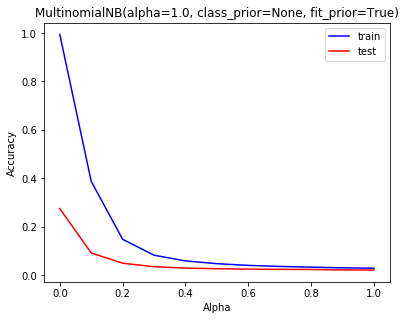

In [70]:
train_acc_uni, test_acc_uni, tune_param, clf_name = tune_clf(X_train, y_train, X_test, y_test, classifier="m_nb" )
plot_tune_clf( train_acc_uni, test_acc_uni, tune_param, clf_name )

In [71]:
train_acc_uni, test_acc_uni, tune_param, clf_name = tune_clf(X_train, y_train, X_test, y_test, classifier="logreg" )
plot_tune_clf( train_acc_uni, test_acc_uni, tune_param, clf_name )

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: T

KeyboardInterrupt: 

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### 3. Clustering

#### 3a. Data preparation

In [72]:
authormovements_df=pd.read_pickle("../2_Preprocessing/processeddata/df_pickle_movements/movements_df.pickle")

# let's randomly extract 10 authors and their movements
authormovements_df10 = authormovements_df.sample(n=10)

# let's get their filenames
datapath = "../2_Preprocessing/processeddata/df_pickles/5_sent/{}_df.pickle"
df_filenames=[datapath.format(authornum) for authornum in authormovements_df10.index]
len(df_filenames)

10

In [73]:
# count unique literary movements
movements = []
for row in authormovements_df10["literarymovements"]:
    movements.extend([i for i in row])
    
movements = set(movements)
print(len(movements), "\n", movements)


19 
 {'satire', 'dark fantasy', 'victorian literature', 'fantasy', 'sermon', 'horror fiction', 'literary realism', 'science fiction', 'weird fiction', 'thriller', 'time travel', 'picaresque', 'mystery', 'historical fiction', 'naturalism', 'modernist poetry in english', 'romance novel', 'christian fiction', 'detective fiction'}


In [74]:
needvect_features = {"lemmas": 
                  {"train": allauthor_df_train["tokens"],
                    "test": allauthor_df_test["tokens"],},
                "namedentities": 
                  {"train": allauthor_df_train['ne_dates']+allauthor_df_train['ne_places'],
                   "test": allauthor_df_test['ne_dates']+allauthor_df_test['ne_places'],}, 
                "filteredtokens": 
                    {"train": allauthor_df_train['filteredtokens']+allauthor_df_train['filteredtokens'],
                   "test": allauthor_df_test['filteredtokens']+allauthor_df_test['filteredtokens'],}}
                # add the ne_dates and ne_places columns for the vectoriser to manage sparsity. leave out 
                # persons for now, it is possible person names can significantly identify authors (except 
                # perhaps authors) 
            
alreadyvect_features=['concreteness', 'subjectivity', "parse_VP"]

make_featuresets(needvect_features, alreadyvect_features, task="clustering")

In [75]:
def stack( A, B ):
    return hstack( [A,B] )

X_tr_lemmas, y_train, X_te_lemmas, y_test = load_data( FEATURESET_CLASS, 
                                                    features='lemmas', task="clustering")
X_tr_concreteness, y_train, X_te_concreteness, y_test = load_data( FEATURESET_CLASS, 
                                                    features='concreteness', task="clustering")
X_tr_namedentities, y_train, X_te_namedentities, y_test = load_data( FEATURESET_CLASS, 
                                                    features='namedentities', task="clustering")
X_tr_parse_VP, y_train, X_te_parse_VP, y_test = load_data( FEATURESET_CLASS, 
                                                    features='parse_VP', task="clustering")
X_tr_subjectivity, y_train, X_te_subjectivity, y_test = load_data( FEATURESET_CLASS, 
                                                    features='subjectivity', task="clustering")
X_tr_filteredtokens, y_train, X_te_filteredtokens, y_test = load_data( FEATURESET_CLASS, 
                                                    features='filteredtokens', task="clustering")


X_train = hstack( [X_tr_subjectivity, X_tr_filteredtokens,X_tr_namedentities, X_tr_parse_VP] )
X_test = hstack( [X_te_subjectivity, X_te_filteredtokens, X_te_namedentities, X_te_parse_VP] )

In [76]:
X_train.shape

(13837, 26634)

In [77]:
X_test.shape

(3518, 26634)

#### 3b. Trying spectral clustering

Spectral clustering provides the most robust performance across different types of [clustering patterns](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py), since we have not been able to dimension reduce meaningfully to plot the distribution of our data (down to 2 or 3 principal component that have substantial explained variance), we don't have a clear idea of the distribution. So we pick spectral clustering as a start. 

In [78]:
spec_clust = SpectralClustering(n_clusters=5, eigen_solver= "amg", n_init=10, n_neighbors=1)
spec_clust.fit(X_train) 

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:288: UserWarning: AMG works better for sparse matrices
  warnings.warn("AMG works better for sparse matrices")
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/pyamg/aggregation/aggregation.py:218: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  n_init=n_init)


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver='amg', eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=5, n_init=10, n_jobs=None, n_neighbors=1,
          random_state=None)

##### PCA to 3 components, to 3D plot

In [81]:
N_COMPONENTS=3
TSVD_model = TruncatedSVD(n_components=N_COMPONENTS, random_state=1,)
X_train_TSVD_model = TSVD_model.fit(X_train)
print("The explained variance for TruncatedSVD with {} is {}".format(N_COMPONENTS, sum(TSVD_model.explained_variance_ratio_)))

The explained variance for TruncatedSVD with 3 is 0.9370659828844858


In [82]:
X_train_TSVD=X_train_TSVD_model.transform(X_train)
X_test_TSVD=X_train_TSVD_model.transform(X_test)

##### 3b1. 5 clusters

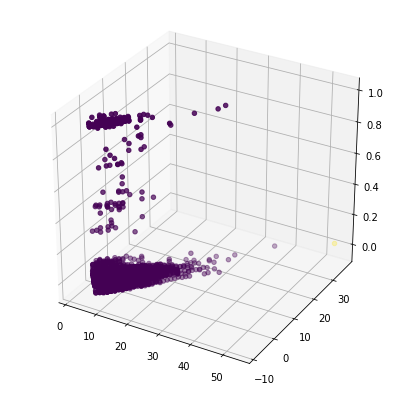

In [83]:
fig = plt.figure(figsize=(7,7))
from mpl_toolkits.mplot3d import Axes3D

# add a subplot for the 3rd dimension 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_TSVD[:,0], 
           X_train_TSVD[:,1],
           X_train_TSVD[:,2],
           c=spec_clust.labels_) # predicted cluster labels

plt.show()